In [59]:
import pandas as pd
import re, ast
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
DATASET_FILE_PATH = "australian_user_reviews.json"

## Data Loading

In [3]:
def parse_steam_date(date_str):
    date_str = date_str.replace("Posted ", "").replace(".", "")
    
    if re.search(r'\d{4}$', date_str):
        fmt = "%B %d, %Y"
    else:
        date_str += ", 2016" 
        fmt = "%B %d, %Y"
        
    try:
        return datetime.strptime(date_str, fmt)
    except ValueError:
        return None 

In [4]:
def parse_helpful(helpful_str):
    if "No ratings yet" in helpful_str:
        return 0.0
    
    match = re.search(r'(\d+) of (\d+)', helpful_str)
    if match:
        numerator = int(match.group(1))
        denominator = int(match.group(2))
        if denominator == 0: return 0.0
        return numerator / denominator
    return 0.0

In [5]:
with open(DATASET_FILE_PATH, 'r', encoding='utf-8') as f:
    data = [ast.literal_eval(line) for line in f]

## Data processing
Removing all the entries with a malformed date entry.

In [6]:
rows = []
for user in data:
    user_id = user['user_id']
    for review in user['reviews']:
        rows.append({
            'user_id': user_id,
            'item_id': review['item_id'],
            'recommend': 1 if review['recommend'] else 0,
            'date': parse_steam_date(review['posted']),
            'helpful_score': parse_helpful(review['helpful']),
            'review_text': review['review'] 
        })

In [7]:
df = pd.DataFrame(rows)
df = df.dropna(subset=['date'])
df = df.sort_values(by='date')

print(f"Total interactions: {len(df)}")
df.head()

Total interactions: 59305


,user_id,item_id,recommend,date,helpful_score,review_text
20764,TheWhipster,39690,1,2010-10-16,0.400000,You'll Be Emo'd by the end of it!
29168,eddy96,40700,1,2010-10-25,0.000000,A very addictive puzzle game with incredible a...
29807,farsel,24010,1,2010-11-19,0.416667,this is the most epic of epics and these train...
29804,farsel,25700,1,2010-11-20,0.714286,"im mad about balls, and this game"
29801,farsel,15320,1,2010-11-20,0.888889,brill plane simulator where you can do some si...


## Data analysis

In [14]:
n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()
n_interactions = len(df)

matrix_size = n_users * n_items
sparsity = (1 - (n_interactions / matrix_size)) * 100

print(f"--- DATASET STATISTICS ---")
print(f"Number of Users: {n_users}")
print(f"Number of Items (Games): {n_items}")
print(f"Total Interactions (Reviews): {n_interactions}")
print(f"Sparsity: {sparsity:.4f}%")
print(f"Date Range: {df['date'].min().date()} to {df['date'].max().date()}")

--- DATASET STATISTICS ---
Number of Users: 25458
Number of Items (Games): 3682
Total Interactions (Reviews): 59305
Sparsity: 99.9367%
Date Range: 2010-10-16 to 2016-09-18


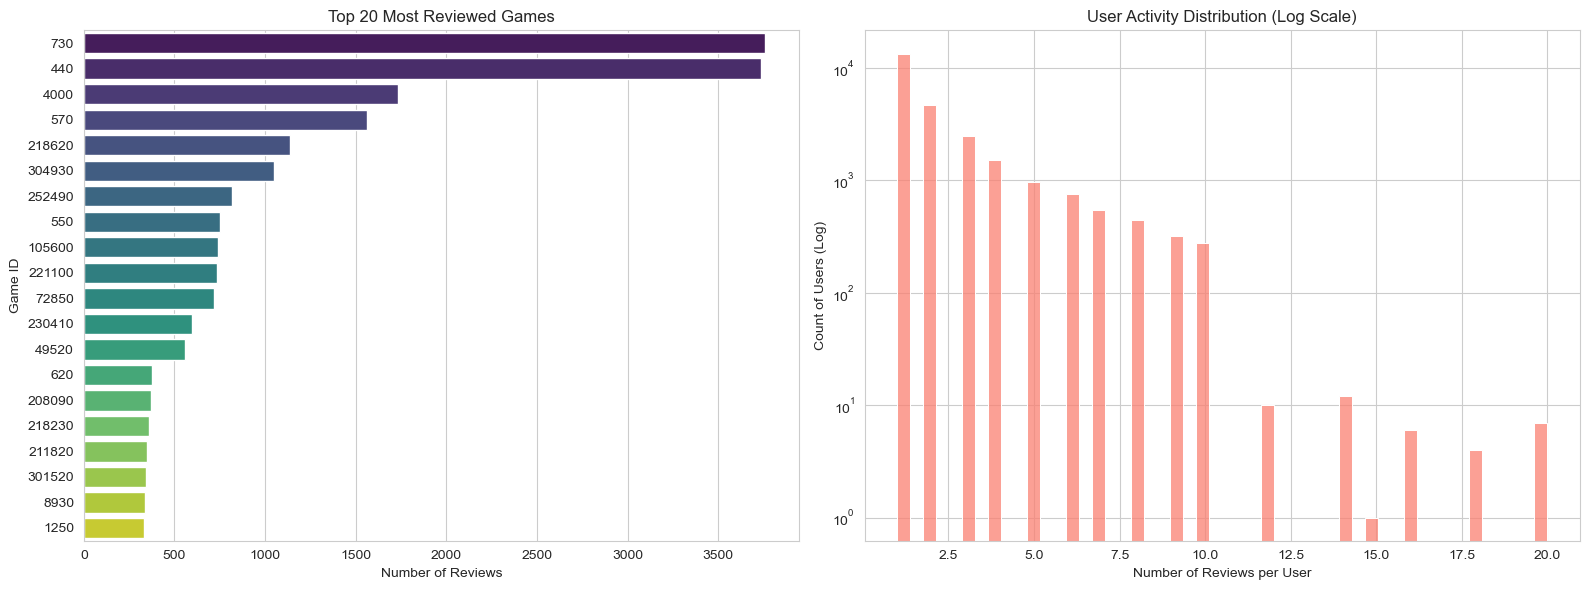

In [ ]:
sns.set_style("whitegrid")

# How many reviews the user made
user_activity = df.groupby('user_id').size()

# How many users that review the item
item_popularity = df.groupby('item_id').size()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Get the top 20 most popular games that were reviewed
top_items = item_popularity.sort_values(ascending=False).head(20)
sns.barplot(x=top_items.values, y=top_items.index.astype(str), ax=ax[0], palette="viridis", hue=top_items.index.astype(str), legend=False)
ax[0].set_title("Top 20 Most Reviewed Games")
ax[0].set_xlabel("Number of Reviews")
ax[0].set_ylabel("Game ID")

# Get the distribution of the number fo reviews per user
# So we that users made less reviews than other reviews
sns.histplot(user_activity, bins=50, ax=ax[1], kde=False, color="salmon")
ax[1].set_yscale('log') # Log scale is here because of the huge variance
ax[1].set_title("User Activity Distribution (Log Scale)")
ax[1].set_xlabel("Number of Reviews per User")
ax[1].set_ylabel("Count of Users (Log)")

plt.tight_layout()
plt.show()

Exploring the distribution of recommended, vs not recommended.

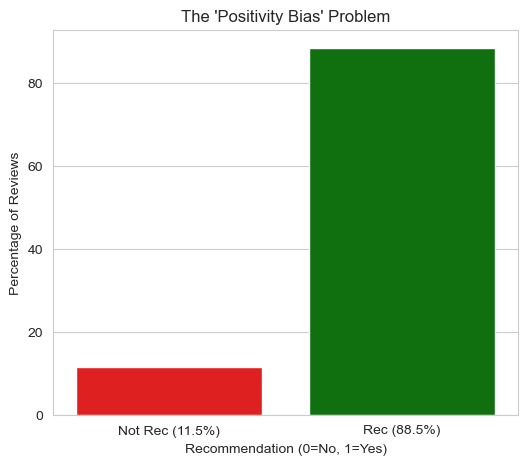

In [ ]:
plt.figure(figsize=(6, 5))
count_data = df['recommend'].value_counts(normalize=True) * 100
sns.barplot(x=count_data.index, y=count_data.values, palette=['red', 'green'], hue=count_data.index, legend=False)
plt.title("The 'Positivity Bias' Problem")
plt.xlabel("Recommendation (0=No, 1=Yes)")
plt.ylabel("Percentage of Reviews")
plt.xticks([0, 1], [f"Not Rec ({count_data[0]:.1f}%)", f"Rec ({count_data[1]:.1f}%)"])
plt.show()

As we can see, the dataset is heavily skewed. Undersampling of the training set will be required to ensure proper training. 

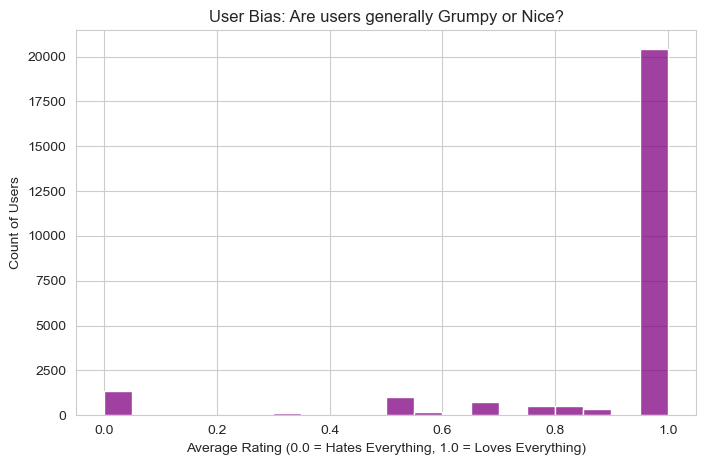

In [15]:
# Calculate the average rating for each user
user_avg_rating = df.groupby('user_id')['recommend'].mean()

plt.figure(figsize=(8, 5))
sns.histplot(user_avg_rating, bins=20, kde=False, color="purple")
plt.title("User Bias: Are users generally Grumpy or Nice?")
plt.xlabel("Average Rating (0.0 = Hates Everything, 1.0 = Loves Everything)")
plt.ylabel("Count of Users")
plt.show()

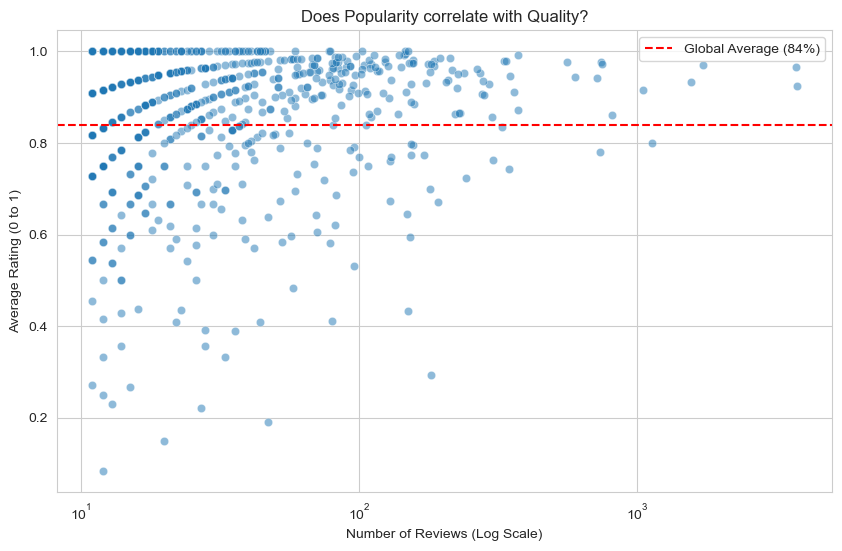

In [16]:
# --- PLOT 5: Popularity vs. Quality ---
item_stats = df.groupby('item_id').agg({'recommend': ['count', 'mean']})
item_stats.columns = ['review_count', 'avg_rating']

# Filter to games with at least 10 reviews (to remove noise)
robust_items = item_stats[item_stats['review_count'] > 10]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=robust_items, x='review_count', y='avg_rating', alpha=0.5)
plt.xscale('log') # Log scale is crucial here
plt.title("Does Popularity correlate with Quality?")
plt.xlabel("Number of Reviews (Log Scale)")
plt.ylabel("Average Rating (0 to 1)")
plt.axhline(0.84, color='r', linestyle='--', label='Global Average (84%)')
plt.legend()
plt.show()

## Utility functions

In [60]:
def plot_confusion_matrix(y_true, y_pred, title="Model"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Rec (0)', 'Rec (1)'])
    
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title(f"Confusion Matrix: {title}")
    plt.grid(False) 
    plt.show()

## Training and testing split

In [20]:
# first, split the RAW (skewed) data
train_raw, test_raw = train_test_split(df, test_size=0.2, stratify=df['recommend'], random_state=42)

# balance only the training set 
train_pos = train_raw[train_raw['recommend'] == 1]
train_neg = train_raw[train_raw['recommend'] == 0]

# downsample the training positives only
train_pos_downsampled = train_pos.sample(n=len(train_neg), random_state=42)
train_balanced = pd.concat([train_pos_downsampled, train_neg]).sample(frac=1)

print(f"Training on {len(train_balanced)} rows (Balanced)")
print(f"Testing on {len(test_raw)} rows (Real-world Skew)")

# train and test set stats
print("Train Set Balance:")
print(train_balanced['recommend'].value_counts())
print("\nTest Set Balance:")
print(test_raw['recommend'].value_counts())

Training on 10932 rows (Balanced)
Testing on 11861 rows (Real-world Skew)
Train Set Balance:
recommend
1    5466
0    5466
Name: count, dtype: int64

Test Set Balance:
recommend
1    10495
0     1366
Name: count, dtype: int64


## Model 1: Recommend Top K Recommended (Baseline)

Calculate the top $K$ most recommended games. For each user, if the game they interacted with is in the top $K$ recommended games, predict recommend. 

In [21]:
y_test = test_raw['recommend'].values
train_pos = train_balanced[train_balanced['recommend'] == 1]
game_popularity = train_pos['item_id'].value_counts()

def popularity_baseline_predict(item_ids, top_k_set):
    return [1 if item in top_k_set else 0 for item in item_ids]

num_unique_train_games = train_balanced['item_id'].nunique()
print(f"Number of unique games in training set: {num_unique_train_games}")

Number of unique games in training set: 1904


--- POPULARITY THRESHOLD BASELINE ---
--- TOP 10 MOST RECOMMENDED GAMES ---
Accuracy: 0.3507
              precision    recall  f1-score   support

           0       0.13      0.85      0.23      1366
           1       0.94      0.29      0.44     10495

    accuracy                           0.35     11861
   macro avg       0.54      0.57      0.33     11861
weighted avg       0.84      0.35      0.41     11861



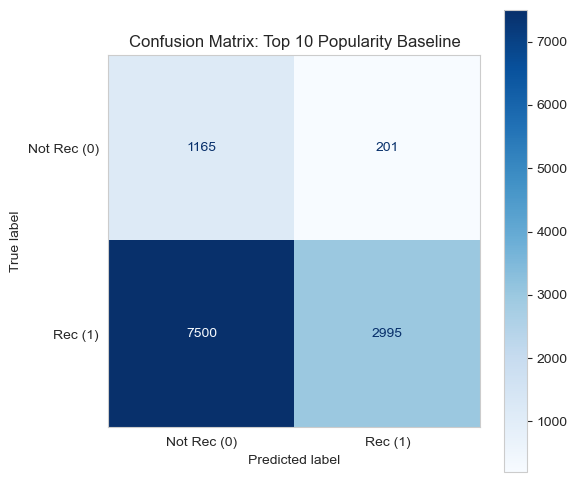

In [61]:
K = 10
top_k_recommended_games = set(game_popularity.head(K).index)
y_pred_pop = popularity_baseline_predict(test_raw['item_id'], top_k_recommended_games)

print("--- POPULARITY THRESHOLD BASELINE ---")
print(f"--- TOP {K} MOST RECOMMENDED GAMES ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_pop):.4f}")
print(classification_report(y_test, y_pred_pop))
plot_confusion_matrix(y_test, y_pred_pop, title=f"Top {K} Popularity Baseline")

Explore how the accuracy changes as $K$ changes. 

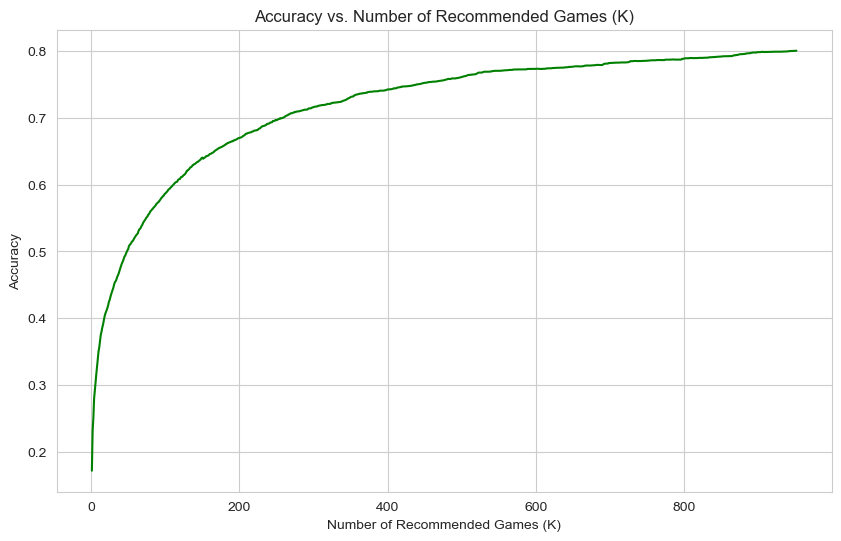

Peak accuracy: 80.02%


In [25]:
accuracies = []
for k in range(1, num_unique_train_games // 2): 
    top_k_recommended_games = set(game_popularity.head(k).index)
    y_pred_pop = popularity_baseline_predict(test_raw['item_id'], top_k_recommended_games)
    accuracies.append(accuracy_score(y_test, y_pred_pop))
    
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, color='green')
plt.title("Accuracy vs. Number of Recommended Games (K)")
plt.xlabel("Number of Recommended Games (K)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

print(f"Peak accuracy: {max(accuracies) * 100:.2f}%")

As we start expanding our set of top $K$ recommended games to include half of the most recommended games in the training set, the accuracy approaches around 80%. This is what we need to beat. 

## Model 2: Word2Vec + Logistic Regression


As it stands, we're currently trying to predict whether a user would like a game given the most k popular games. As it stands, only leads to a 20% accuracy. What we would by trying is taking a look at the reviews of the game and see if the user like the game or not. 


In [26]:
# Solution 2
# We'll define a representation for the document and use that representation to determine whether or the user recommends a game
# or not
# Let's start by using a word2vec model
from gensim.models import Word2Vec
import nltk
nltk.download('corpus')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
from sklearn import linear_model


[nltk_data] Error loading corpus: Package 'corpus' not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jishnuraychaudhuri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Firstly, we create our sentences from the training data
def preprocess_text(df):
    # Create list of sentences, which is a list of words for each text in the training data
    setences = []
    outcomes = []

    # Set up to filter out the punctuation and stopwords from the text
    # Including a stemming algorithm as well
    punctuation = set(string.punctuation)
    filter = set(stopwords.words('english'))
    porter = PorterStemmer()

    for index, row in df.iterrows():
        # If the text is NaN 
        text = row["review_text"]

        # Firstly cover the text to capital 
        r = ''.join([c for c in text.lower() if c not in punctuation])

        # Next split the words
        words = r.split()

        # Filter out the words for stop words
        #words = [word for word in words if not word in filter]

        # Stem the words out
        words = [porter.stem(word) for word in words]

        if len(words) == 0:
            #print(text)
            words = ["<unk>"]

        # Add words to setneces
        setences.append(words)
        outcomes.append(row["recommend"])
    
    return setences, outcomes



In [39]:
train_df = train_balanced.dropna(subset=['review_text'])
train_df = train_df[train_df['review_text'].apply(lambda x: not x.isspace())]
test_df = test_raw.dropna(subset=['review_text'])
test_df = test_df[test_df['review_text'].apply(lambda x: not x.isspace())]

print(f"Training Set Size: {len(train_df)} interactions")
print(f"Test Set Size:     {len(test_df)} interactions")
print(f"Users in Test Set: {test_df['user_id'].nunique()}")
print(f"Total Users:       {df['user_id'].nunique()}")
print(f"Num entried dropped from training set: {len(train_balanced) - len(train_df)}")
print(f"Num entried dropped from test set: {len(test_raw) - len(test_df)}")


Training Set Size: 10931 interactions
Test Set Size:     11859 interactions
Users in Test Set: 9068
Total Users:       25458
Num entried dropped from training set: 1
Num entried dropped from test set: 2


In [40]:
sentences = preprocess_text(train_df)

In [41]:
# Next create word2vec model
def train_word2vec(sentences, min_count=1, vector_size=10, window=3, sg=0):
    model = Word2Vec(sentences, vector_size=vector_size, min_count=min_count, window=window, sg=sg)
    return model

In [42]:
# We want to create a text representation of the words, so we have to combine the word embeddigns from word2vec
def create_sentence_embedding(sentence, model):
    # Go through each word in the sentence
    sentence_embed = []

    for word in sentence:
        if word in model.wv.key_to_index:
            sentence_embed.append(np.array(model.wv[word]))
        else:
            sentence_embed.append(np.array(model.wv['<unk>']))
    sentence_embed = np.array(sentence_embed).mean(axis=0)
    return sentence_embed

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Training Accuracy: 76.58036776141249%
Test Accuracy: 75.8411333164685%


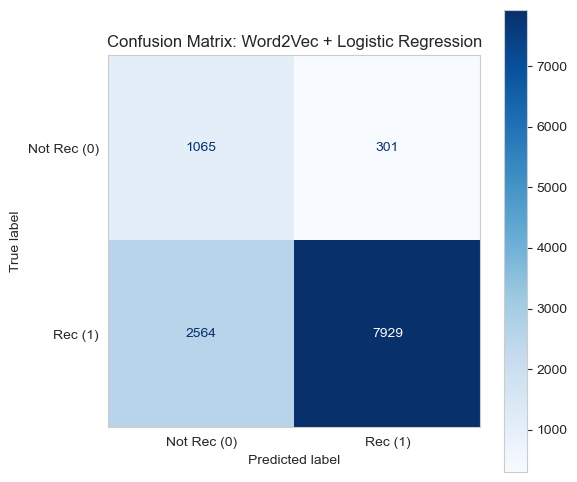

In [62]:
# Next, create a neural network that will take a sentence embedding and predict whether the user will recommend the game 
# Or not
# We could simply using a logistic regression algorithm with the word embeddings

train_sentences, train_outcomes = preprocess_text(train_df)
test_sentences, test_outcomes  = preprocess_text(test_df)

word_model = train_word2vec(train_sentences,sg=1,window=8, vector_size=64)
train_sentences = np.array([create_sentence_embedding(sentence, word_model) for sentence in train_sentences])
test_sentences = np.array([create_sentence_embedding(sentence, word_model) for sentence in test_sentences])

log_model = linear_model.LogisticRegression(penalty='l2', class_weight='balanced', C=1, max_iter=500)
log_model.fit(train_sentences, train_outcomes)


test_predictions = log_model.predict(test_sentences)
train_predcitions = log_model.predict(train_sentences)
train_correct = train_predcitions == train_outcomes
test_correct = test_predictions == test_outcomes

train_correct = sum(train_correct) / len(train_correct)
test_correct = sum(test_correct) / len(test_correct)

print(f"Training Accuracy: {train_correct * 100}%")
print(f"Test Accuracy: {test_correct * 100}%")

plot_confusion_matrix(test_outcomes, test_predictions, title="Word2Vec + Logistic Regression")


## Model 3: Using Average Game and User Reviews

In [55]:
train_df.head()

,user_id,item_id,recommend,date,helpful_score,review_text
21376,ZoomZoom0,303210,1,2015-10-01,0.000000,"Words, Words can not describe the rollar coast..."
42523,76561198040611679,304930,0,2014-07-13,0.083333,terrible
28629,deejmyster,265630,0,2016-04-23,0.285714,This game is ehh.
40150,sketchyfletchy,247000,0,2015-04-25,0.500000,"Oh, Talisman. I forgot what a broken lie your ..."
46979,76561198038567931,221100,0,2014-06-19,0.555556,currently in alpha this is a waste of money 0/...


In [46]:
from collections import defaultdict

In [56]:
#Solution 3 Predict whether or not a user recommends a game using weights of the average rating the, the average user rating and the average game rating.
game_average_rating = defaultdict(dict)
user_average_rating = defaultdict(dict)
for index,row in train_df.iterrows():
    game_average_rating[row['item_id']] = {'sum':0,'count':0}
    user_average_rating[row['user_id']] = {'sum':0,'count':0}
for index,row in train_df.iterrows():
    game_average_rating[row['item_id']]['sum'] += row['recommend']
    game_average_rating[row['item_id']]['count'] += 1
    user_average_rating[row['user_id']]['sum'] += row['recommend']
    user_average_rating[row['user_id']]['count'] += 1
for user in user_average_rating.keys():
    current_dict = user_average_rating[user]
    user_average_rating[user] = {'sum':current_dict['sum'],'count':current_dict['count'],'average':current_dict['sum']/current_dict['count']}
for game in game_average_rating.keys():
    current_dict = game_average_rating[game]
    game_average_rating[game] = {'sum':current_dict['sum'],'count':current_dict['count'],'average':current_dict['sum']/current_dict['count']}

In [57]:
def predict(data,game_average_rating,user_average_rating):
    #predict based on user_average_rating
    pred = []
    for index,row in data.iterrows():
        if (user_average_rating[row['user_id']]):
            if user_average_rating[row['user_id']]['average'] > .5:
                pred.append(1)
                continue
            else:
                pred.append(0)
                continue
        elif (game_average_rating[row['item_id']]):
            if game_average_rating[row['item_id']]['average'] > .5:
                pred.append(1)
                continue
            else:
                pred.append(0)
                continue
        else:
            pred.append(1)
    return pred
train_predict = predict(train_df,game_average_rating,user_average_rating)
test_predict = predict(test_df,game_average_rating,user_average_rating)

In [ ]:
train_correct = np.array(train_predict) == np.array(train_outcomes)
test_correct = np.array(test_predict) == np.array(test_outcomes)

train_correct = sum(train_correct) / len(train_correct)
test_correct = sum(test_correct) / len(test_correct)

print(f"Training Accuracy: {train_correct * 100}%")
print(f"Test Accuracy: {test_correct * 100}%")

Training Accuracy: 91.40975208123685%
Test Accuracy: 64.54169828821992%


Test Predictions
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273

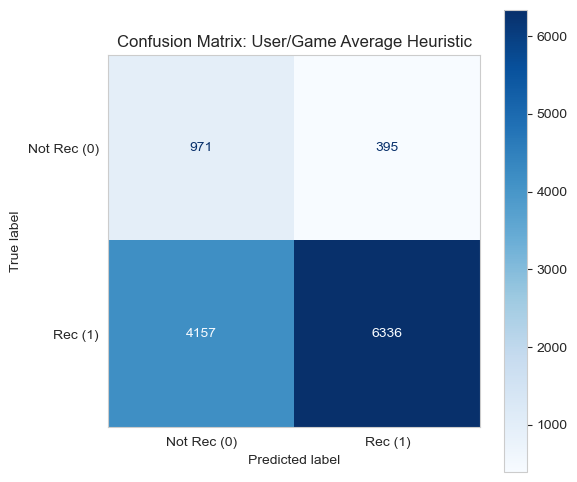

In [63]:
def predict2(data,game_average_rating,user_average_rating,lamb = 1):
    #predict based on user_average_rating
    pred = []
    count = 0
    for index,row in data.iterrows():
        user_weight = .5
        game_weight = .5
        if (user_average_rating[row['user_id']]):
            user_weight = user_average_rating[row['user_id']]['average']
        elif (game_average_rating[row['item_id']]):
            game_weight = game_average_rating[row['item_id']]['average']
        if not user_average_rating[row['user_id']]:
            count += 1
            print(count)
        pred.append(1 if ((user_weight)+(game_weight))/2 - .01 >= .5 else 0)
    return pred
train_predict = predict2(train_df,game_average_rating,user_average_rating)
print("Test Predictions")
test_predict = predict2(test_df,game_average_rating,user_average_rating)
print(train_predict)

plot_confusion_matrix(test_outcomes, test_predict, title="User/Game Average Heuristic")